# get_gdps

This routine grabs the latest Global Deterministic Prediction System (GDPS) model data from MSC Datamart and outputs png plots into designated product folders for each ACMWF product.

**Datamart:**

https://eccc-msc.github.io/open-data/msc-data/nwp_gdps/readme_gdps-datamart_en/#levels

https://dd.weather.gc.ca/model_gem_global/

**Outputs:**

```config.json``` specifies the folder structure in which these figures are saved.

Mountain Weather Forecast -> *500 mbar, Surface*

Temperatures -> *1500m 0400, 1500m 1600*

Surface Maps -> *0-144 Hours* 

500 mbar & Precipitable Water -> *500 mbar, Precipitable Water* 


**Maintenance:**

For bug reports, suggestions, inquiries, contact Andrew.Loeppky@gmail.com

In [1]:
from herbie import Herbie
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.weight"] = "heavy"
from toolbox import EasyMap, pc
import cartopy.crs as ccrs
import cartopy.feature as feature
import pandas as pd

from matplotlib.patches import Rectangle
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pytz
import os, shutil
import json

import warnings

# supress because removal of old datafiles is handled outside herbie
warnings.filterwarnings("ignore")

from bmwflib import (
    clear_directory,
    get_var,
    make_figure,
    plot_cities,
    make_basemap,
    make_title,
)

%load_ext jupyter_black

 ╭─▌▌Herbie─────────────────────────────────────────────╮
 │ WARNING: Unable to create config file               │
 │      /Users/andrew/.config/herbie/config.toml        │
 │ Herbie will use standard default settings.           │
 │ Consider setting env variable HERBIE_CONFIG_PATH.    │
 ╰──────────────────────────────────────────────────────╯



In [2]:
def plot_500(fxx, ds, config):
    """
    plots the 500mb figure for the MWF and 500mb pages
    """
    fig, ax = make_figure()
    ax.set_extent([-155, -117, 40, 64])

    # basemap
    make_basemap(ax)

    # plot height contours
    ht = ax.contour(
        ds.longitude,
        ds.latitude,
        ds.gh.loc[{"isobaricInhPa": 500}],
        colors="k",
        transform=pc,
        levels=range(0, 6000, 50),
    )
    ax.clabel(ht, inline=True, fontsize=9)

    # plot thickness contours
    th_cmap = mpl.colors.ListedColormap(
        [
            "pink",
            "blue",
            "orange",
        ]
    )
    th_bounds = [4800, 5100, 5400, 5700]
    th_norm = mpl.colors.BoundaryNorm(th_bounds, th_cmap.N)
    ht = ax.contour(
        ds.longitude,
        ds.latitude,
        ds.thick,
        cmap=th_cmap,
        norm=th_norm,
        linestyles="dashed",
        transform=pc,
        levels=range(4000, 6000, 60),
    )
    ax.clabel(ht, inline=True, fontsize=9)

    # plot cloud cover
    cc_cmap = mpl.colors.ListedColormap(["#DCDCDC", "#808080"])
    cc_bounds = [60, 80, 100]
    cc_norm = mpl.colors.BoundaryNorm(cc_bounds, cc_cmap.N)
    cc = ax.pcolormesh(
        ds.longitude,
        ds.latitude,
        ds.TCDC.where(ds.TCDC >= 60),
        cmap=cc_cmap,
        norm=cc_norm,
        antialiased=True,
        transform=pc,
    )

    # plot precip rate
    pr_cmap = mpl.colors.ListedColormap(
        [
            "#90EE90",
            "#ADFF2F",
            "#3CB371",
            "#2E8B57",
            "#FFFF00",
            "#FFA500",
            "#B22222",
            "#8B008B",
        ]
    )
    pr_bounds = [1, 2, 5, 10, 20, 30, 50, 75, 100]
    pr_norm = mpl.colors.BoundaryNorm(pr_bounds, pr_cmap.N)
    pr = ax.pcolormesh(
        ds.longitude,
        ds.latitude,
        ds.prate.where(ds.prate >= 1),
        cmap=pr_cmap,
        norm=pr_norm,
        antialiased=True,
        transform=pc,
    )

    # precip colorbar
    fig.text(0.121, 0.649, "6hr Pcpn", color="black", size=10)
    fig.text(0.12, 0.65, "6hr Pcpn", color="white", size=10)

    fig.text(0.121, 0.639, "(mm)", color="black", size=10)
    fig.text(0.12, 0.64, "(mm)", color="white", size=10)

    pr_cbar = fig.colorbar(
        pr,
        cmap=pr_cmap,
        norm=pr_norm,
        ax=ax,
        spacing="uniform",
        shrink=0.25,
        location="left",
        aspect=10,
        anchor=(0.15, 0.55),
        pad=-0.15,
    )
    pr_cbar.ax.tick_params(
        labelsize=10,
        labelcolor="white",
        length=0,
        labelright=True,
        labelleft=False,
    )

    # cloud cover colorbar
    fig.text(0.121, 0.399, "Cloud Cover", color="black", size=10)
    fig.text(0.12, 0.40, "Cloud Cover", color="white", size=10)

    fig.text(0.121, 0.389, "(%)", color="black", size=10)
    fig.text(0.12, 0.39, "(%)", color="white", size=10)

    cc_cbar = fig.colorbar(
        cc,
        cmap=cc_cmap,
        norm=cc_norm,
        ax=ax,
        spacing="uniform",
        shrink=0.125,
        location="left",
        aspect=5,
        anchor=(0.15, 0.25),
        pad=-0.18,
    )
    cc_cbar.ax.tick_params(
        labelsize=10,
        labelcolor="white",
        length=0,
        labelright=True,
        labelleft=False,
    )

    make_title(fig, ax, ds, "500 mb\nHeight", offset=0.03)

    # save and close the figure
    fig.savefig(
        os.path.join(
            config["plots"]["mwf500"],
            f"mwf_{ds.model}_{pd.Timestamp(ds.time.values).strftime('%Y_%_h_%d')}_{pd.Timestamp(ds.time.values).strftime("%H")}Z_P{fxx}",
        )
    )
    fig.savefig(
        os.path.join(
            config["plots"]["500mb"],
            f"500mb_{ds.model}_{pd.Timestamp(ds.time.values).strftime('%Y_%_h_%d')}_{pd.Timestamp(ds.time.values).strftime('%H')}Z_P{fxx}",
        )
    )
    fig.clf()

    return None

In [3]:
def plot_surf(fxx, ds, config):
    """
    plots the surface figure for mwf day 3-4, surface 0-144h
    """
    fig, ax = make_figure()
    ax.set_extent([-155, -117, 40, 64])

    # basemap
    make_basemap(ax)

    # plot height contours
    ht = ax.contour(
        ds.longitude,
        ds.latitude,
        ds.prmsl,
        colors="k",
        transform=pc,
        levels=range(900, 1100, 4),
    )
    ax.clabel(ht, inline=True, fontsize=9)

    # plot thickness contours
    th_cmap = mpl.colors.ListedColormap(
        [
            "pink",
            "blue",
            "orange",
        ]
    )
    th_bounds = [4800, 5100, 5400, 5700]
    th_norm = mpl.colors.BoundaryNorm(th_bounds, th_cmap.N)
    ht = ax.contour(
        ds.longitude,
        ds.latitude,
        ds.thick,
        cmap=th_cmap,
        norm=th_norm,
        linestyles="dashed",
        transform=pc,
        levels=range(4000, 6000, 60),
    )
    ax.clabel(ht, inline=True, fontsize=9)

    # plot cloud cover
    cc_cmap = mpl.colors.ListedColormap(["#DCDCDC", "#808080"])
    cc_bounds = [60, 80, 100]
    cc_norm = mpl.colors.BoundaryNorm(cc_bounds, cc_cmap.N)
    cc = ax.pcolormesh(
        ds.longitude,
        ds.latitude,
        ds.TCDC.where(ds.TCDC >= 60),
        cmap=cc_cmap,
        norm=cc_norm,
        antialiased=True,
        transform=pc,
    )

    # plot precip rate
    pr_cmap = mpl.colors.ListedColormap(
        [
            "#90EE90",
            "#ADFF2F",
            "#3CB371",
            "#2E8B57",
            "#FFFF00",
            "#FFA500",
            "#B22222",
            "#8B008B",
        ]
    )
    pr_bounds = [1, 2, 5, 10, 20, 30, 50, 75, 100]
    pr_norm = mpl.colors.BoundaryNorm(pr_bounds, pr_cmap.N)
    pr = ax.pcolormesh(
        ds.longitude,
        ds.latitude,
        ds.prate.where(ds.prate >= 1),
        cmap=pr_cmap,
        norm=pr_norm,
        antialiased=True,
        transform=pc,
    )

    # precip colorbar
    fig.text(0.121, 0.649, "6hr Pcpn", color="black", size=10)
    fig.text(0.12, 0.65, "6hr Pcpn", color="white", size=10)

    fig.text(0.121, 0.639, "(mm)", color="black", size=10)
    fig.text(0.12, 0.64, "(mm)", color="white", size=10)

    pr_cbar = fig.colorbar(
        pr,
        cmap=pr_cmap,
        norm=pr_norm,
        ax=ax,
        spacing="uniform",
        shrink=0.25,
        location="left",
        aspect=10,
        anchor=(0.15, 0.55),
        pad=-0.15,
    )
    pr_cbar.ax.tick_params(
        labelsize=10,
        labelcolor="white",
        length=0,
        labelright=True,
        labelleft=False,
    )

    # cloud cover colorbar
    fig.text(0.121, 0.399, "Cloud Cover", color="black", size=10)
    fig.text(0.12, 0.40, "Cloud Cover", color="white", size=10)

    fig.text(0.121, 0.389, "(%)", color="black", size=10)
    fig.text(0.12, 0.39, "(%)", color="white", size=10)

    cc_cbar = fig.colorbar(
        cc,
        cmap=cc_cmap,
        norm=cc_norm,
        ax=ax,
        spacing="uniform",
        shrink=0.125,
        location="left",
        aspect=5,
        anchor=(0.15, 0.25),
        pad=-0.18,
    )
    cc_cbar.ax.tick_params(
        labelsize=10,
        labelcolor="white",
        length=0,
        labelright=True,
        labelleft=False,
    )

    make_title(fig, ax, ds, "Surface", offset=0.03)

    # save and close the figure
    if fxx >= 72:  # only save mwf maps for day 3+
        fig.savefig(
            os.path.join(
                config["plots"]["mwfsurf"],
                f"surf_{ds.model}_{pd.Timestamp(ds.time.values).strftime('%Y_%_h_%d')}_{pd.Timestamp(ds.time.values).strftime('%H')}Z_P{fxx}",
            )
        )
    fig.savefig(
        os.path.join(
            config["plots"]["surf"],
            f"surf_{ds.model}_{pd.Timestamp(ds.time.values).strftime('%Y_%_h_%d')}_{pd.Timestamp(ds.time.values).strftime('%H')}Z_P{fxx}",
        )
    )
    fig.clf()

    return None

In [ ]:
def plot_temps(fxx, ds, config):
    """
    plots 1500m temperatures, saves at 0400 and 1600 PST (0500 and 1700 PDT)
    """
    fig, ax = make_figure()
    ax.set_extent([-155, -117, 40, 64])

    # basemap
    make_basemap(ax)

    # plot 850mb temps
    t_cmap = mpl.colors.ListedColormap(
        [
            "#FFFAFA",
            "#C0C0C0",
            "#4B0082",
            "#8B008B",
            "#9400D3",
            "#9370DB",
            "#0000CD",
            "#1E90FF",
            "#00BFFF",
            "#F0E68C",
            "#FFFF00",
            "#FFA500",
            "#FF4500",
            "#d62728",
            "#FF69B4",
            "#800000",
            "#000000",
        ]
    )
    t_bounds = [
        -40,
        -35,
        -30,
        -25,
        -20,
        -15,
        -10,
        -5,
        -1,
        1,
        5,
        10,
        15,
        20,
        25,
        30,
        35,
        40,
    ]
    t_norm = mpl.colors.BoundaryNorm(t_bounds, t_cmap.N)
    t = ax.pcolormesh(
        ds.longitude,
        ds.latitude,
        ds.t,
        cmap=t_cmap,
        norm=t_norm,
        antialiased=True,
        transform=pc,
    )

    # 1500m temp colorbar
    fig.text(0.141, 0.689, "($^o$C)", color="black", size=10)
    fig.text(0.14, 0.69, "($^o$C)", color="white", size=10)

    t_cbar = fig.colorbar(
        t,
        cmap=t_cmap,
        norm=t_norm,
        ax=ax,
        spacing="uniform",
        shrink=0.6,
        location="left",
        aspect=20,
        anchor=(0.15, 0.25),
        pad=-0.18,
    )
    t_cbar.ax.set_yticks(t_bounds)
    t_cbar.ax.tick_params(
        labelsize=10,
        labelcolor="white",
        length=0,
        labelright=True,
        labelleft=False,
    )

    # cities
    plot_cities(ax)

    # title
    make_title(fig, ax, ds, "Temperature\n1500 meters", offset=0.03)

    # only save the plot at 0400 (0500 DST) or 1600 (1700 DST)
    the_date = (
        pd.Timestamp(ds.valid_time.values)
        .tz_localize("UTC")
        .tz_convert("America/Vancouver")
    )
    if the_date.hour in (4, 5):
        fig.savefig(
            os.path.join(
                config["plots"]["temp1504"],
                f"temp1500_{ds.model}_{pd.Timestamp(ds.time.values).strftime('%Y_%_h_%d')}_{pd.Timestamp(ds.time.values).strftime('%H')}Z_P{fxx}",
            )
        )
    if the_date.hour in (16, 17):
        fig.savefig(
            os.path.join(
                config["plots"]["temp1516"],
                f"temp1500_{ds.model}_{pd.Timestamp(ds.time.values).strftime('%Y_%_h_%d')}_{pd.Timestamp(ds.time.values).strftime('%H')}Z_P{fxx}",
            )
        )
    fig.clf()

In [5]:
def do_gdps(run, fxx, config):
    """
    creates all gdps dependent plots for forecast time fxx
    """
    # clear the gdps data folder
    clear_dir = [clear_directory(file) for file in list(config["data"].values())]

    # heights to pull geopotentials
    hgt = ["ISBL_1000", "ISBL_500"]

    # get all the data and merge it into one big xarray
    temp = get_var(run, "gdps", fxx, "TMP", "ISBL_850")
    tcdc = get_var(run, "gdps", fxx, "TCDC", "SFC_0")
    prate = get_var(run, "gdps", fxx, "PRATE", "SFC_0")
    height = xr.concat(
        [get_var(run, "gdps", fxx, "HGT", h) for h in hgt], dim="isobaricInhPa"
    )
    pres = get_var(run, "gdps", fxx, "PRMSL", "MSL_0")
    ds = xr.merge([temp, tcdc, prate, height, pres])

    # slice out only the domain we care about
    ds = ds.sel(longitude=slice(-195, -97), latitude=slice(30, 73))

    # convert precip from kg/m3/s to mm/6h
    ds["prate"] *= 3600 * 6

    # convert sea level pressure to hPa
    ds["prmsl"] /= 100

    # convert temps from kelvin to degC
    ds["t"] -= 273.15

    # calculate 1000 - 500mb thickness
    ds["thick"] = ds.gh.loc[{"isobaricInhPa": 500}] - ds.gh.loc[{"isobaricInhPa": 1000}]

    # make the plots
    plot_500(fxx, ds, config)
    plot_surf(fxx, ds, config)
    plot_temps(fxx, ds, config)

    return None

In [6]:
def main(tstep=range(3, 148, 3)):
    """
    main function to generate all gdps plots for a forecast run
    (default 144h with 3h increments)
    """
    # time of last model run (0Z and 12Z)
    now = pd.Timestamp.utcnow().floor("12h").tz_localize(None)

    # config determines the directories in which to save each graphic
    with open("..//config/gdps_config.json") as f:
        config = json.load(f)

    clear_dir = [clear_directory(file) for file in list(config["plots"].values())]
    gdps = [do_gdps(now, fxx, config) for fxx in tstep]

    return None

✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-07 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None
👨🏻‍🏭 Created directory: [/Users/andrew/data/gdps/20250607]
✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-07 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-07 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-07 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-07 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-07 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-07 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None
👨🏻‍🏭 Created directory: [/Users/andrew/data/gdps/20250607]
✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-07 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=gdps ┊ product=15km/grib2/

✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-07 12:00 UTC F24 ┊ GRIB2 @ msc ┊ IDX @ None
👨🏻‍🏭 Created directory: [/Users/andrew/data/gdps/20250607]
✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-07 12:00 UTC F24 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-07 12:00 UTC F24 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-07 12:00 UTC F24 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-07 12:00 UTC F24 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-07 12:00 UTC F24 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-07 12:00 UTC F27 ┊ GRIB2 @ msc ┊ IDX @ None
👨🏻‍🏭 Created directory: [/Users/andrew/data/gdps/20250607]
✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-07 12:00 UTC F27 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=gdps ┊ product=15km/grib2/

KeyboardInterrupt: 

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

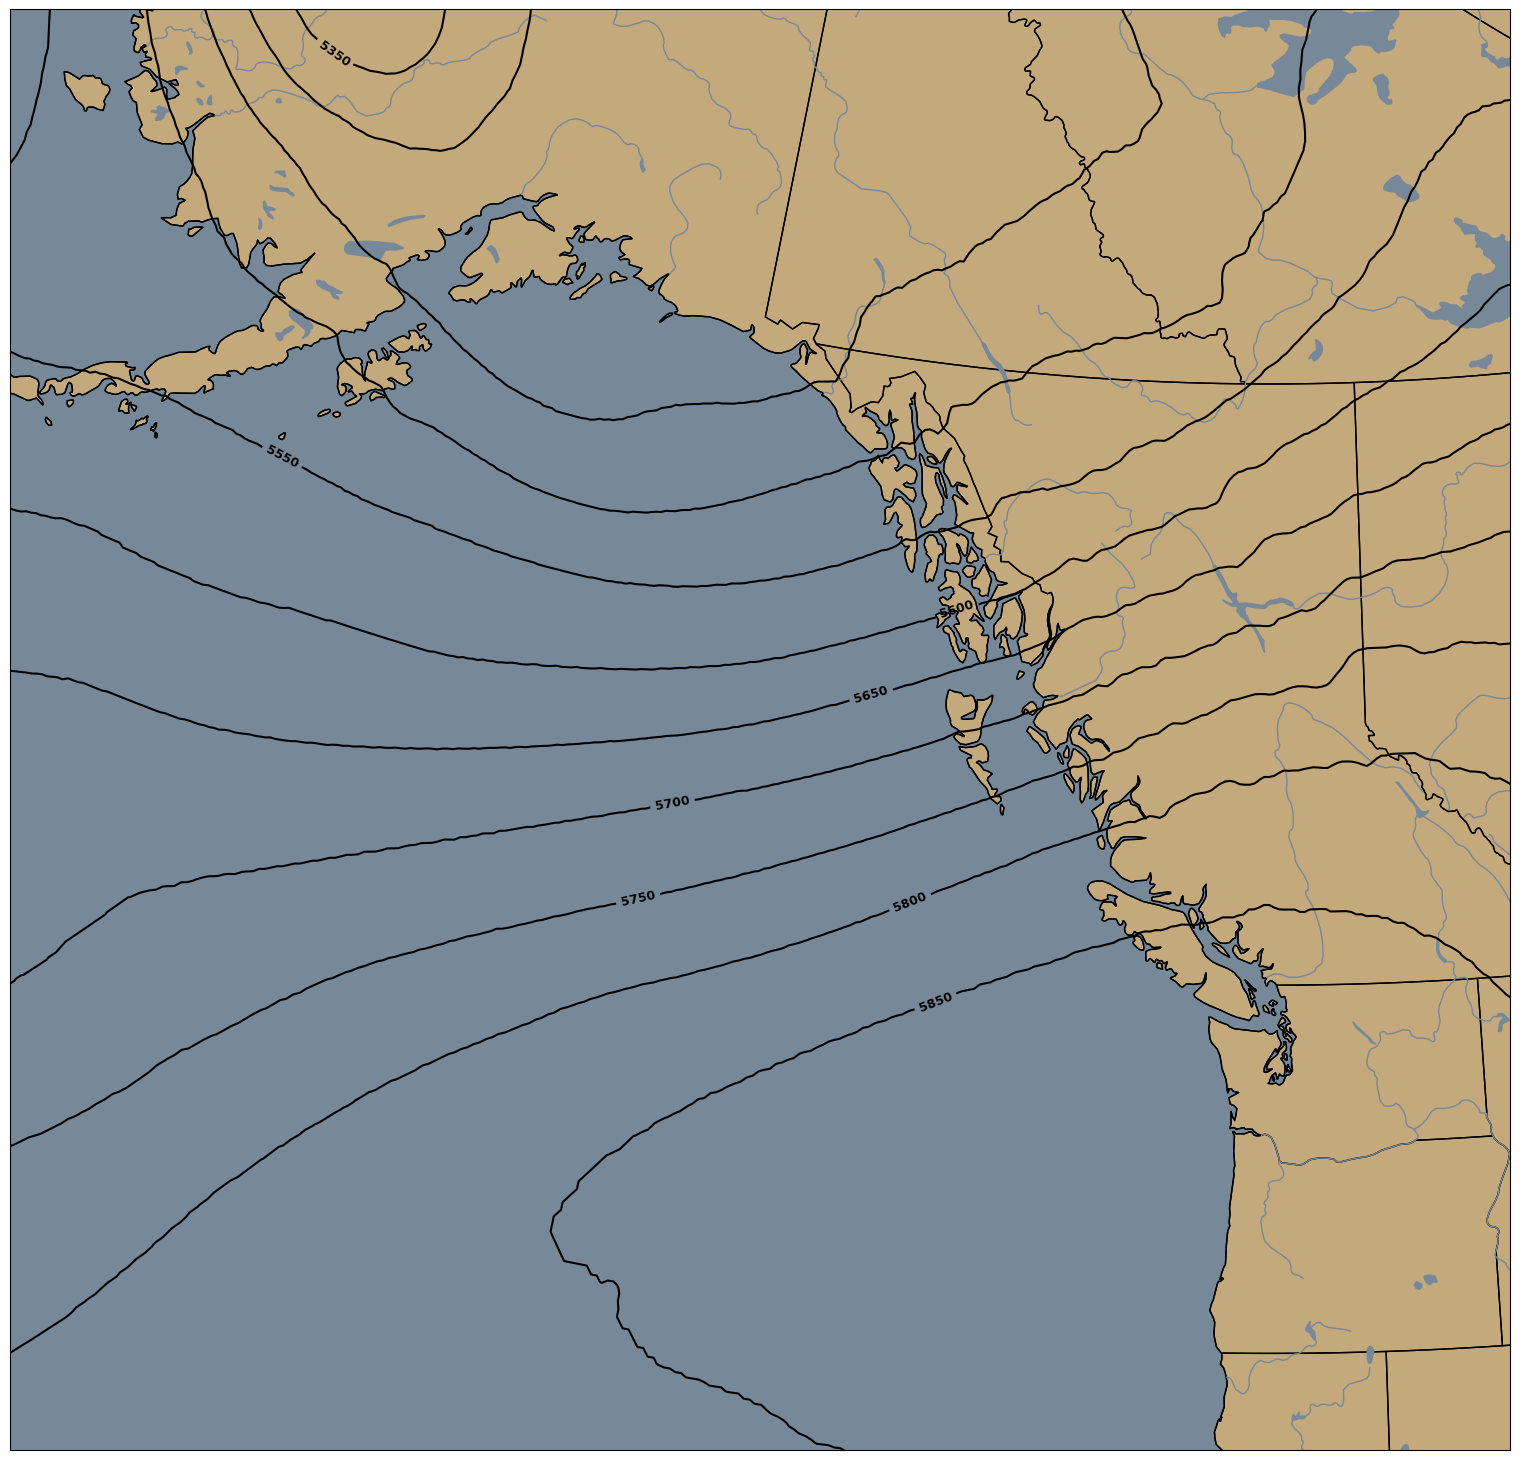

In [7]:
if __name__ == "__main__":
    main()